# Training Deep Neural Networks

if you need to tackle a complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper DNN

Training a deep DNN isn’t a walk in the park. Here are
some of the problems you could run into :

- You may be faced with the tricky *vanishing gradients* (gradient decreasing close to 0 can't update Weight) problem or the related *exploding gradients* (gradient increasing to infiny or NAN) problem.
- Training may be extremely slow

In this chapter we will go through each of these problems and present
techniques to solve them. 

## The Vanishing/Exploding Gradients Problems

the combination of the popular logistic sigmoid activation function and
the weight initialization technique that was most popular at the time (i.e.,
a normal distribution with a mean of 0 and a standard deviation of 1). the fact
that the logistic function has a mean of 0.5, not 0

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
def sigmoid(z) :
    return 1 / (1 + np.exp(-z))

<img src='satur.png' />

> the function saturates at 0 or 1 

> Thus, when backpropagation kicks in it has virtually no gradient to propagate backthrough the network; and what little gradient exists keeps getting **diluted as backpropagation** progresses down through the top layers, so there is **really nothing left for the lower layers**.

Glorot(Xavier) and He Initialization

a way to significantly alleviate the unstable gradients problem

<img src="init.png"/>

> By default, Keras uses Glorot initialization with a uniform distribution.

In [3]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

Glorot and Bengio proposed a good compromise that has
proven to work very well in practice: the connection weights of each
layer must be initialized randomly as described in Equation 11-1, where
fan-avg = (fan-in + fan-out )/2

> - Fan-in: is a term that defines the maximum number of inputs that a system can accept. 
> - Fan-out: is a term that defines the maximum number of inputs that the output of a system can feed to other systems.

> Glorot initialization can speed up training considerably, and it is
one of the tricks that led to the success of Deep Learning

In [4]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

In [5]:
init = keras.initializers.VarianceScaling(scale=.2, mode='fan_avg', distribution='uniform') # set custom initialze random weight
keras.layers.Dense(10, activation='relu', kernel_initializer=init)

### Nonsaturating Activation Functions

> Glorot and Bengio was that the
problems with unstable gradients were in part due to a poor choice of activation function.

ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute).

> ReLU activation function is not perfect. It suffers from
a problem known as the dying ReLUs: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU. 

In [6]:
def leaky_relu(z, alpha=0.01) :
    return np.maximum(alpha*z, z)

> The hyperparameter α defines how much the function 'leaks': ensures that leaky ReLUs never die;

paper also evaluated the randomized leaky ReLU (RReLU), where α is picked randomly, seemed to act as a regularizer

Finally, the paper evaluated the parametric leaky ReLU (PReLU), where α is authorized to be learned during training

> PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.


activation function called the exponential linear unit (ELU) that outperformed all the ReLU variants (slower to
compute than the ReLU function)

Günter Klambauer et al. introduced the Scaled
ELU (SELU) activation function:

> SELU activation
function often significantly outperforms other activation functions for
such neural nets (will selfnormalize: the output of each layer will tend to preserve a mean of 0 and 
standard deviation of 1 during training, which solves the
vanishing/exploding gradients problem) [The network’s architecture must be sequential. Unfortunately, if you
try to use SELU in nonsequential architectures, such as recurrent networks will not necessarily outperform other
activation functions]

> - The input features must be standardized (mean 0 and standard deviation 1).
> - Every hidden layer’s weights must be initialized with LeCun normal
initialization. In Keras, this means setting
kernel_initializer="lecun_normal" .


in general SELU > ELU > leaky
ReLU (and its variants) > ReLU > tanh > logistic
- If the network’s architecture prevents it from self-normalizing, then ELU
-  care a lot about runtime latency, then you may
prefer leaky ReLU. (0.3 for leaky ReLU)
- If you have spare time and computing power, you can use cross-validation to evaluate other
activation functions, such as RReLU if your network is overfitting or PReLU if you
have a huge training set

> if speed is your priority, ReLU might still be the best choice.

<img src="leak.png"/>

In [7]:
[activation for activation in dir(keras.activations) if not activation.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [8]:
[layer for layer in dir(keras.layers) if "relu" in layer.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [9]:
#for use SELU
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")
layer

### Batch Normalization
scale it to 0 mean and 1 variance and  scale it add plus Bias term(called offset)

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems ( doesn’t guarantee that they
won’t come back during training.)

adding an operation in the model just before or after the activation function of each hidden layer

<img src="bn.png" />

source : https://www.youtube.com/watch?v=yXOMHOpbon8

the operation lets the model learn the optimal
scale and mean of each of the layer’s inputs.

if you add a
BN layer as the very first layer of your neural network, you do not need to
standardize your training set (The vanishing gradients problem was
strongly reduced, to the point that they could use saturating activation
functions such as the tanh and even the logistic activation function)

Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at
each layer

In [10]:
image_tensor = tf.random.uniform(shape=(3,3), minval=0, maxval=1)
print(image_tensor)

tf.Tensor(
[[0.8351579  0.694469   0.09321904]
 [0.12849092 0.86160636 0.40815735]
 [0.7946682  0.8283142  0.7110379 ]], shape=(3, 3), dtype=float32)


In [11]:
bn_layers = keras.layers.BatchNormalization()(image_tensor)
print(bn_layers)

tf.Tensor(
[[0.83474064 0.694122   0.09317247]
 [0.12842673 0.8611759  0.40795344]
 [0.7942712  0.82790035 0.71068263]], shape=(3, 3), dtype=float32)


In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(), # do not to do manually normalize
    keras.layers.Dense(300, activation="relu" , use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(), # add BN before activation
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation="softmax")
])

> the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer has some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:

> The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after

> you can experiment with this too to see which option works best on
your dataset. To add the BN layers before the activation functions, you
must remove the activation function from the hidden layers and add
them as separate layers after the BN layers.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 300)               235200    
                                                                 
 batch_normalization_2 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)               30000     
                                                                 
 batch_normalization_3 (Batc  (None, 100)              4

As you can see, each BN layer adds four parameters per input: γ, β, μ, and
σ (for example, the first BN layer adds 3,136 parameters, which is 4 × 784).

> The last two parameters, μ and σ, are the moving averages; they are not
affected by backpropagation, so Keras calls them “non-trainable

In [14]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_1/gamma:0', True),
 ('batch_normalization_1/beta:0', True),
 ('batch_normalization_1/moving_mean:0', False),
 ('batch_normalization_1/moving_variance:0', False)]

### Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is
to clip the gradients during backpropagation so that they never exceed
some threshold

This technique is most
often used in recurrent neural networks

In [15]:
# just a matter of setting the clipvalue or clipnorm argument when creating an optimizer
keras.optimizers.SGD(clipvalue=1.0)

> clipvalue (float) is set, the gradient of each weight is clipped to be no higher than this value (maximum value set)

### Reusing Pretrained Layers

not a good idea to train a very large DNN from scratch( find an existing neural network that accomplishes a similar task to the one you are trying to tackle ) then reuse the lower layers of this
network. This technique is called transfer learning

>  transfer learning will work best when the inputs have similar low-level features.

> The output layer of the original model should usually be replaced because may not have the right number of outputs for the new task.

> the upper hidden layers of the original model are less likely to be as useful as the lower layers

> It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

In [ ]:
# model A is pretrained model then use taht transfer to model B
model_A = keras.models.load_model('model_A.h5') # multiclass

In [ ]:
# avoid affect of training (we B train will affect to A)
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1]) # transfer trained layer
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid')) # just binary class

In [ ]:
# freeze layers
for layer in model_B_on_A.layers[:-1] :
    layer.trainable = False # freeze

> You must always compile your model after you freeze or unfreeze layers.

Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training
to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to
avoid damaging the reused weights:

> Transfer learning works
best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers)

### Unsupervised Pretraining

you don’t have
much labeled training data, you may still be able to perform *unsupervised pretraining*

you can try to use it to train
an unsupervised model, such as an autoencoder or a generative adversarial network

Then you can reuse the lower layers of the
autoencoder or the lower layers of the GAN’s discriminator, add the output layer for your task on top, and fine-tune the final network using supervised learning 

## Faster Optimizers

### Momentum Optimization
Imagine a bowling ball rolling down a gentle slope on a smooth surface: it
will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity.

Momentum optimization cares a great deal about what previous gradients were: at each iteration (the gradient is used for acceleration, not for speed)

prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, called
the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

momentum optimization to escape from plateaus much faster than Gradient
Descent.

In [16]:
momentum = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) # prevent overshoot and oscillate

> the momentum value of 0.9 usually works well in practice and almost always goes faster than regular Gradient Descent.


### Nesterov Accelerated Gradient
also known
as Nesterov momentum optimization 

This small tweak works because in general the momentum vector will be
pointing in the right direction (i.e., toward the optimum)

NAG is generally faster than regular momentum optimization.

In [19]:
nesterov = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### AdaGrad
It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum

this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. 

This is called
an *adaptive learning rate*. It helps point the resulting updates more directly toward the global optimum.

AdaGrad frequently performs well for simple quadratic problems, but it
often stops too early when training neural networks. The learning rate
gets scaled down so much that the algorithm ends up stopping.


### RMSProp
Root Mean Squared Propagation

AdaGrad runs the risk of slowing down a bit too fast and
never converging to the global optimum

The RMSProp algorithm fixes
this by accumulating only the gradients from the most recent iterations , It does so
by using exponential decay in the first step

The decay rate β is typically set to 0.9


In [20]:
rmsp = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

> Note that the rho argument corresponds to β

> In fact, it was the preferred optimization algorithm of
many researchers until Adam optimization came around.

### Adam and Nadam Optimization
which stands for* adaptive moment estimation*, combines the
ideas of momentum optimization and RMSProp:

just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp

The momentum decay hyperparameter $β_1$ is typically initialized to 0.9,
while the scaling decay hyperparameter $β_2$ is often initialized to 0.999

In [21]:
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

> it requires less tuning of the learning rate hyperparameter η.
You can often use the default value η = 0.001, making Adam even easier to
use than Gradient Descent.


compares all the optimizers we’ve discussed so far (* is bad, **
is average, and *** is good).

<img src="optimizers.png" width=400px/>

## Learning Rate Scheduling

if you start with a
large learning rate and then reduce it once training stops making fast
progress (faster than with the optimal constant learning rate)

 It can also be beneficial to start with a low
learning rate, increase it, then drop it again. These strategies are called
learning schedules

### Power Scheduling

lr = lr0 / (1 + steps / s)**c

Keras uses c=1 and s = 1 / decay

The learning rate drops
at each step. After s steps, it is down to η / 2. After s more steps, it is
down to η / 3, then it goes down to η / 4, then η / 5, and so on

In [24]:
optimizes = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

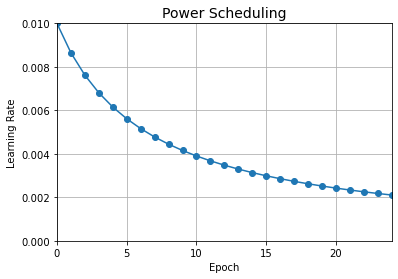

In [37]:
import math

n_epochs = 25
lr0 = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(50000 / batch_size) # ceiling up decimal point
epochs = np.arange(n_epochs)
lrs = lr0 / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential scheduling
lr = lr0 * 0.1**(epoch / s)

The learning rate will gradually drop by a factor of 10 every s steps

In [47]:
def exponential_decay_fn(epoch) :
    return 0.01 * 0.1**(epoch / 20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

> If you want to update the learning rate at each iteration(per batch) rather than at each epoch, you must write your own callback class:



In [51]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback) :
    def __init__(self, s=40000) :
        super().__init__()
        self.s = s 

    def on_batch_begin(self, batch, logs=None) :
        # batch argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate) # get current learning rate
        K.set_value(self.model.optimizer.learning_rate, lr*0.1**(1/self.s)) # set new learning rate value

    def on_epoch_end(self, epoch, logs=None) :
        logs = logs or  {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate) 

exp_decay = ExponentialDecay(s = 20 * len(X_train) // 32) # number of steps in 20 epochs (batch size = 32)
history = model.fit(callbacks=[exp_decay])

### Performance scheduling
Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error
stops dropping.


In [55]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5) # multiply 0.2 to lr if not improve loss for 5 epochs

### 1cycle scheduling
increase and decreas lr cycle.

In [56]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,  self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len('X_train') / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(callbacks=[onecycle])

## Avoiding Overfitting Through Regularization
great flexibility
also makes the network prone to overfitting the training set. We need
regularization.

we will examine other popular
regularization techniques for neural networks: ℓ and ℓ regularization,
dropout, and max-norm regularization

### $ℓ_1$ and $ℓ_2$ Regularization

use $ℓ_2$ regularization to constrain a neural network’s connection weights, and/or $ℓ_1$
regularization if you want a sparse model (with many weights equal to 0)

In [60]:
keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01

Since you will typically want to apply the same regularizer to all layers in
your network

you may find yourself repeating the same arguments. This makes the code ugly and error-prone

In [66]:
from functools import partial

regularize_dense = partial(
    keras.layers.Dense, activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=keras.regularizers.l2(0.01)
)

model = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=(28,28)),
    regularize_dense(200),
    regularize_dense(100),
    regularize_dense(10, activation='softmax', kernel_initializer='glorot_uniform'),
])

### Dropout

randomly dropping out nodes during training.

it will be entirely ignored during this training step, but it may be active during the
next step 

The hyperparameter p is called the dropout
rate, and it is typically set between 10% and 50%

In [68]:
model = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(200, activation='relu'),
    # ...
])

> In practice, you can usually apply dropout only to the neurons in the top one to three layers (excluding the output layer).


If you want to regularize a self-normalizing network based on the SELU activation
function, you should use alpha dropout (instead of regular dropout because regular dropout would break self normalization):

**Monte Carlo (MC) Dropout**

boost the performance of any trained dropout
model without having to retrain it or even modify it at all, provides a
much better measure of the model’s uncertainty, and is also amazingly
simple to implement.


Here we get an array with 100 output predictions for every test data we give. So we can run simple mean to see what the model thinks the output class should be on an average. We can also easily calculate the standard deviation in this sample.

In [ ]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba  = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

> Note that model(X) is similar to model.predict(X) except it returns a
tensor rather than a NumPy array

The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak

If your model contains other layers that behave in a special way during
training (such as BatchNormalization layers), then you should not force you should replace the Dropout
layers with the following MCDropout class

In [73]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

### Max-Norm Regularization

: Constrains the weights incident to each hidden unit to have a norm less than or equal to a desired value.

In [78]:
keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                   kernel_constraint=keras.constraints.max_norm(max_value=1., axis=0)) #the maximum norm value for the incoming weights

> ts of shape [number of inputs, number of
neurons], so using axis=0 means that the max-norm constraint will apply independently to each neuron’s weight vector. If you want to use
max-norm with convolutional layers , make sure to set
the max_norm() constraint’s axis argument appropriately (usually
axis=[0, 1, 2] ).
